In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')

In [2]:
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%time
gc.enable()

train = pd.read_csv('training_set.csv')
# Features to compute with tsfresh library. Fft coefficient is meant to capture periodicity
fcp = {'fft_coefficient': [{'coeff': 0, 'attr': 'abs'},{'coeff': 1, 'attr': 'abs'}],'kurtosis' : None, 'skewness' : None}

def featurize(df):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    # train[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]


    aggs = {
        'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
        'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
        'detected': ['mean'],
        'flux_ratio_sq':['sum','skew'],
        'flux_by_flux_ratio_sq':['sum','skew'],
    }

    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [
        k + '_' + agg for k in aggs.keys() for agg in aggs[k]
    ]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    # Add more features with 
    agg_df_ts = extract_features(df, column_id='object_id', column_sort='mjd', column_kind='passband', column_value = 'flux', default_fc_parameters = fcp, n_jobs=4)
    # Add smart feature that is suggested here https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69696#410538
    # dt[detected==1, mjd_diff:=max(mjd)-min(mjd), by=object_id]
    df_det = df[df['detected']==1].copy()

    agg_df_mjd = extract_features(df_det, column_id='object_id', column_value = 'mjd', default_fc_parameters = {'maximum':None, 'minimum':None}, n_jobs=4)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd['mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on = 'id')
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id',inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df

agg_train = featurize(train)

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 22.84it/s]


CPU times: user 20.5 s, sys: 706 ms, total: 21.2 s
Wall time: 24.4 s


In [5]:
%%time
meta_train = pd.read_csv('training_set_metadata.csv')
meta_train.head()

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

train_id = full_train['object_id']

if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
train_mean = full_train.mean(axis=0)
full_train.fillna(0, inplace=True)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
CPU times: user 44.5 ms, sys: 8.05 ms, total: 52.5 ms
Wall time: 51.5 ms


In [6]:
# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(x='gain', y='feature', data=importances_.sort_values('mean_gain', ascending=False))
    plt.tight_layout()
    plt.savefig('importances.png')

In [7]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'learning_rate': 0.03,
    'subsample': .9,
    'colsample_bytree': 0.5,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'n_estimators': 1000,
    'silent': -1,
    'verbose': -1,
    'max_depth': 3
}

# Compute weights
w = y.value_counts()
weights = {i : np.sum(w) / w[i] for i in w.index}

oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
    trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
    val_x, val_y = full_train.iloc[val_], y.iloc[val_]

    clf = lgb.LGBMClassifier(**lgb_params)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50,
        sample_weight=trn_y.map(weights)
    )
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, oof_preds[val_, :]))

    imp_df = pd.DataFrame()
    imp_df['feature'] = full_train.columns
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y, y_preds=oof_preds))

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.823312	training's wloss: 0.814592	valid_1's multi_logloss: 1.17391	valid_1's wloss: 0.975378
[200]	training's multi_logloss: 0.561937	training's wloss: 0.549992	valid_1's multi_logloss: 0.948143	valid_1's wloss: 0.779778
[300]	training's multi_logloss: 0.443828	training's wloss: 0.431355	valid_1's multi_logloss: 0.858464	valid_1's wloss: 0.729607
[400]	training's multi_logloss: 0.373768	training's wloss: 0.361323	valid_1's multi_logloss: 0.812475	valid_1's wloss: 0.715619
[500]	training's multi_logloss: 0.323574	training's wloss: 0.311564	valid_1's multi_logloss: 0.781346	valid_1's wloss: 0.709771
[600]	training's multi_logloss: 0.285535	training's wloss: 0.274299	valid_1's multi_logloss: 0.760263	valid_1's wloss: 0.712334
Early stopping, best iteration is:
[553]	training's multi_logloss: 0.302224	training's wloss: 0.290621	valid_1's multi_logloss: 0.769127	valid_1's wloss: 0.708526
0.708525

In [8]:
full_train.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_diff,flux_dif2,flux_w_mean,flux_dif3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,mwebv
0,-1100.440063,660.626343,-123.096998,-89.477524,394.109851,-0.349540,2.130510,12.845472,4.482743,3.835269,1.744747,1.623740,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,1761.066406,-14.306331,-327.742307,-5.373326,205.036926,1628.427737,-1.475181,0.128917,22370.594834,2806.374162,-1.255123,0.415580,7780.500807,2805.598113,-1.409885,0.339918,7024.003068,2536.068846,-1.449858,0.293128,3245.366349,2741.539785,-1.548319,0.200096,2704.641265,2893.344217,-1.592820,0.125268,873.7903,0.0000,0.0000,0.017
1,-14.735178,14.770886,-1.423351,-0.873033,6.471144,0.014989,0.639458,9.115748,2.359620,1.998217,1.509888,1.633246,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,29.506064,-20.730002,-4.884564,-6.040676,190.427851,299.586559,-1.014003,0.260052,57.109047,192.539229,-1.097170,-0.087865,44.477327,191.057528,-1.188472,-0.022678,55.270113,212.522263,-1.142896,-0.167176,50.414646,203.892482,-1.190245,-0.064134,100.473776,143.963093,-0.797047,0.218182,846.8017,1.6267,0.2552,0.007
2,-19.159811,47.310059,2.267434,0.409172,8.022239,3.177854,0.695106,11.281384,2.471061,1.990851,1.721134,1.823726,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,66.469870,29.315018,25.373110,2.619697,3.461790,4.729538,0.474215,0.356910,7.334944,13.515895,0.976374,0.471342,124.845250,119.500254,5.131290,2.385066,168.280524,162.799417,7.125665,2.662075,219.745132,202.532898,6.081065,2.537802,231.509177,199.286370,3.583130,1.680352,78.7737,0.2262,0.0157,0.021
3,-15.494463,220.795212,8.909206,1.035895,27.558208,4.979826,0.567170,55.892746,2.555576,1.819875,3.537324,10.741655,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,236.289675,26.521968,152.835617,1.546038,129.421659,123.298327,4.629801,2.023211,320.174052,280.440312,50.868880,7.007099,543.845781,491.548270,36.088137,5.688194,807.123762,710.721942,16.392533,3.751603,735.528417,680.055280,13.747434,3.476420,591.037583,523.503586,12.134629,3.170857,123.6872,0.2813,1.1523,0.007
4,-16.543753,143.600189,7.145702,1.141288,20.051722,4.406298,0.695277,11.383690,2.753004,2.214854,1.933837,1.794938,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,160.143942,22.411225,87.856390,1.822792,41.639721,32.987125,0.822496,-0.332169,268.808929,207.812015,6.112295,2.377222,594.150153,498.509820,10.343254,3.075437,643.020183,555.512641,14.095862,3.603208,574.553907,524.107264,16.377058,3.904008,393.114268,357.907185,14.434470,3.657305,133.9113,0.2415,0.0176,0.024


In [11]:
written_train_file = pd.concat([full_train,y,train_id],axis=1)

In [12]:
print(written_train_file.shape)

(7848, 51)


In [13]:
written_train_file.to_csv("train_metadata_kaggle.csv",index=False)

In [14]:
del written_train_file
gc.collect()

823

Normalized confusion matrix


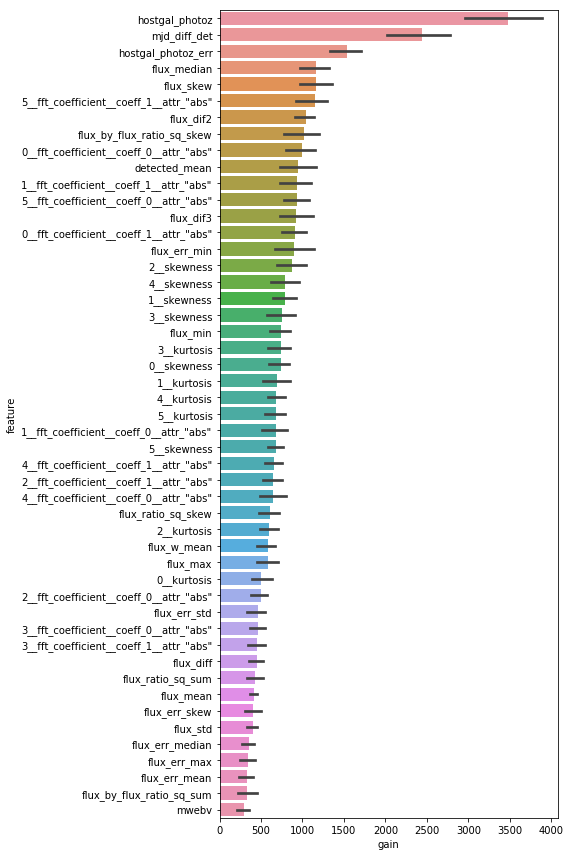

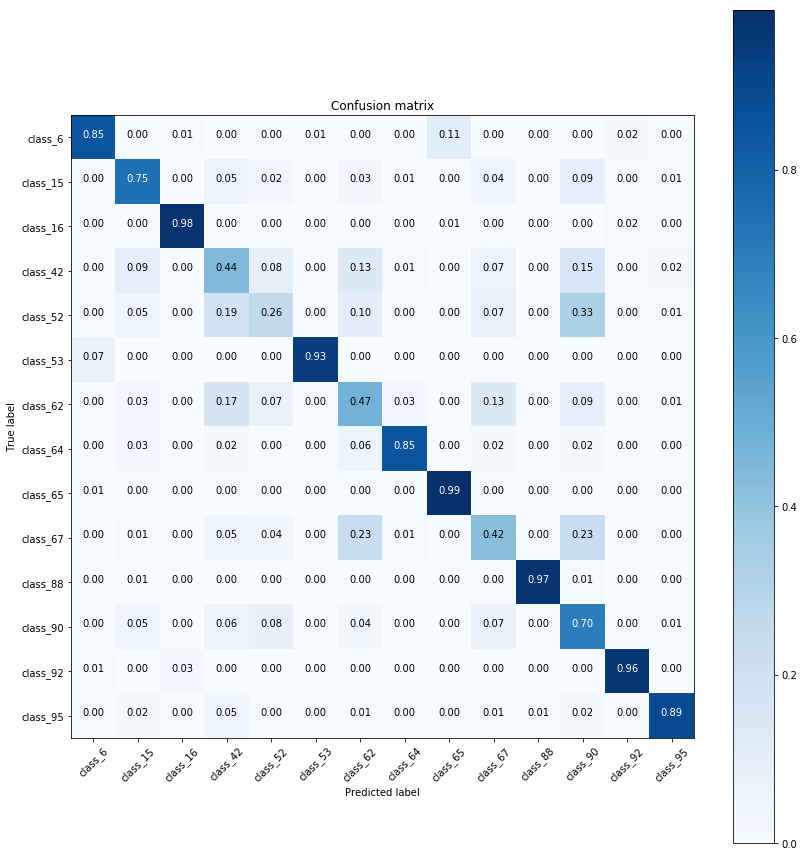

In [15]:
save_importances(importances_=importances)
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [16]:
def predict_chunk(df_, clfs_, meta_, features, train_mean):
    # Group by object id    
    agg_ = featurize(df_)
    # Merge with meta data
    full_test = agg_.reset_index().merge(
        right=meta_,
        how='left',
        on='object_id'
    )

    full_test = full_test.fillna(0)
    # Make predictions
    preds_ = None
    for clf in clfs_:
        if preds_ is None:
            preds_ = clf.predict_proba(full_test[features]) / len(clfs_)
        else:
            preds_ += clf.predict_proba(full_test[features]) / len(clfs_)

    # Compute preds_99 as the proba of class not being any of the others
    # preds_99 = 0.1 gives 1.769
    preds_99 = np.ones(preds_.shape[0])
    for i in range(preds_.shape[1]):
        preds_99 *= (1 - preds_[:, i])

    # Create DataFrame from predictions
    preds_df_ = pd.DataFrame(preds_, columns=['class_' + str(s) for s in clfs_[0].classes_])
    preds_df_['object_id'] = full_test['object_id']
    preds_df_['class_99'] = 0.14 * preds_99 / np.mean(preds_99)
    print(full_test[['object_id'] + features].shape)
    return full_test[['object_id'] + features] , preds_df_

In [17]:
%%time
meta_test = pd.read_csv('test_set_metadata.csv')
# meta_test.set_index('object_id',inplace=True)
import time

start = time.time()
chunks = 10000000
remain_df = None

for i_c, df in enumerate(pd.read_csv('test_set.csv', chunksize=chunks, iterator=True)):
    # Check object_ids
    # I believe np.unique keeps the order of group_ids as they appear in the file
    unique_ids = np.unique(df['object_id'])
    new_remain_df = df.loc[df['object_id'] == unique_ids[-1]].copy()
    if remain_df is None:
        df = df.loc[df['object_id'].isin(unique_ids[:-1])]
    else:
        df = pd.concat([remain_df, df.loc[df['object_id'].isin(unique_ids[:-1])]], axis=0)
    # Create remaining samples df
    remain_df = new_remain_df
    full_test2,preds_df = predict_chunk(df_=df,
                             clfs_=clfs,
                             meta_=meta_test,
                             features=list(full_train.columns),
                             train_mean=train_mean)

    if i_c == 0:
        preds_df.to_csv('predictions.csv', header=True, mode='a', index=False)
    else:
        preds_df.to_csv('predictions.csv', header=False, mode='a', index=False)
    if i_c == 0:
        full_test2.to_csv('test_metadata_kaggle.csv', header=True, mode='a', index=False)
    else:
        full_test2.to_csv('test_metadata_kaggle.csv', header=False, mode='a', index=False)

    del preds_df,full_test2
    gc.collect()
    
    print('%15d done in %5.1f minutes' % (chunks * (i_c + 1), (time.time() - start) / 60), flush=True)

# Compute last object in remain_df
full_test2,preds_df = predict_chunk(df_=remain_df,
                         clfs_=clfs,
                         meta_=meta_test,
                         features=list(full_train.columns),
                         train_mean=train_mean)
print("no problem")
print(preds_df.shape,full_test2.shape)
preds_df.to_csv('predictions.csv', header=False, mode='a', index=False)
full_test2.to_csv('test_metadata_kaggle.csv', header=False, mode='a', index=False)

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


(30320, 50)
       10000000 done in   1.5 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


(74021, 50)
       20000000 done in   4.8 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.39it/s]


(78126, 50)
       30000000 done in   8.3 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.35it/s]


(78147, 50)
       40000000 done in  11.9 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.36it/s]


(78133, 50)
       50000000 done in  15.4 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.43it/s]


(78154, 50)
       60000000 done in  18.9 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s]


(78194, 50)
       70000000 done in  22.7 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]


(78141, 50)
       80000000 done in  26.2 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.47it/s]


(78128, 50)
       90000000 done in  29.7 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.43it/s]


(78188, 50)
      100000000 done in  33.3 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.34it/s]


(78056, 50)
      110000000 done in  36.8 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.37it/s]


(78157, 50)
      120000000 done in  40.3 minutes


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.36it/s]


(78178, 50)
      130000000 done in  44.5 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.46it/s]


(78134, 50)
      140000000 done in  50.3 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]


(78178, 50)
      150000000 done in  55.4 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s]


(78142, 50)
      160000000 done in  59.7 minutes


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


(78152, 50)
      170000000 done in  64.8 minutes


Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.33it/s]


(78167, 50)
      180000000 done in  69.6 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


(78160, 50)
      190000000 done in  74.3 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.37it/s]


(78111, 50)
      200000000 done in  77.8 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


(78144, 50)
      210000000 done in  82.3 minutes


Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


(78024, 50)
      220000000 done in  88.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


(78062, 50)
      230000000 done in  93.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


(78132, 50)
      240000000 done in  97.2 minutes


Feature Extraction: 100%|██████████| 20/20 [00:08<00:00,  3.02it/s]


(78169, 50)
      250000000 done in 102.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.45it/s]


(78155, 50)
      260000000 done in 106.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


(78121, 50)
      270000000 done in 110.8 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


(78132, 50)
      280000000 done in 115.5 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.46it/s]


(78161, 50)
      290000000 done in 119.0 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


(78136, 50)
      300000000 done in 122.5 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


(78180, 50)
      310000000 done in 126.0 minutes


Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


(78101, 50)
      320000000 done in 129.6 minutes


Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.65it/s]


(78202, 50)
      330000000 done in 134.6 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


(78220, 50)
      340000000 done in 139.6 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.46it/s]


(78116, 50)
      350000000 done in 143.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


(78110, 50)
      360000000 done in 146.6 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.32it/s]


(78147, 50)
      370000000 done in 150.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.40it/s]


(78091, 50)
      380000000 done in 153.6 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


(78153, 50)
      390000000 done in 157.0 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


(78118, 50)
      400000000 done in 160.5 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.43it/s]


(78153, 50)
      410000000 done in 164.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


(78170, 50)
      420000000 done in 167.6 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


(78127, 50)
      430000000 done in 171.1 minutes


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


(78130, 50)
      440000000 done in 175.0 minutes


Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.41it/s]


(78112, 50)
      450000000 done in 178.5 minutes


Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  9.54it/s]


(28537, 50)
      460000000 done in 179.9 minutes


Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 1769.00it/s]


(1, 50)
no problem
(1, 16) (1, 50)
CPU times: user 4h 27min 37s, sys: 4min 58s, total: 4h 32min 35s
Wall time: 3h 2s


In [18]:
%%time
z = pd.read_csv('predictions.csv')
print("Shape BEFORE grouping:",z.shape)
z = z.groupby('object_id').mean()
print("Shape AFTER grouping:",z.shape)
z.to_csv('test_pred_4.csv', index=True)

Shape BEFORE grouping: (3492891, 16)
Shape AFTER grouping: (3492890, 15)
CPU times: user 1min 44s, sys: 2.54 s, total: 1min 46s
Wall time: 1min 46s


In [19]:
%%time
test_metadata_kaggle = pd.read_csv('test_metadata_kaggle.csv')

CPU times: user 44.3 s, sys: 1.65 s, total: 45.9 s
Wall time: 45.9 s


In [26]:
test_metadata_kaggle[test_metadata_kaggle['object_id'] == 1171843]

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_diff,flux_dif2,flux_w_mean,flux_dif3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,mwebv
655998,1171843,-43.239304,87.945724,9.878548,4.297537,25.248132,1.205664,1.626278,58.762863,15.319946,12.929250,12.352962,1.111919,0.060000,1179.611954,5.276412,54070.977423,4.601668,131.185028,13.279789,45.837936,2.861931,29.543740,10.528462,2.892583,1.418967,11.813572,11.111491,0.426555,0.738809,65.750540,68.270422,5.648938,2.332189,208.475560,193.288685,2.556040,1.673243,291.860861,369.010501,0.114968,0.982330,380.410484,187.573157,0.593615,0.570881,84.8859,0.2003,0.9714,0.076
729552,1171843,-4.434452,76.682594,21.616262,18.395049,20.998406,0.818194,1.994868,41.668655,13.830012,9.032417,11.995295,1.063101,0.066667,206.602842,2.131427,6282.744816,2.641575,81.117046,3.752594,30.409770,2.667467,59.816594,29.589778,0.000000,1.636618,19.283468,12.860215,3.353735,1.787064,24.980934,16.528596,-1.094593,-0.388405,140.182843,20.891052,-2.787097,0.568555,182.965174,80.594688,-1.999273,-0.308526,221.258833,43.898283,0.343258,-0.039024,33.1112,0.2003,0.9714,0.076
